# CNN with Balanced Test Set And gradio App


In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, resample
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# 🚀 Load dataset
with open("drive/MyDrive/images.pkl", "rb") as f:
    X = pickle.load(f)  # Array of images

with open("drive/MyDrive/target.pkl", "rb") as f:
    y = pickle.load(f)  # Array of labels

# Define the target image size
TARGET_SIZE = (128, 128)

# Resize images to a uniform shape
X_resized = [cv2.resize(img, TARGET_SIZE) for img in X]

# Convert to NumPy arrays
X = np.array(X_resized)
y = np.array(y)

# ✅ Normalize images (scale to [0,1] range)
X = X.astype("float32") / 255.0

# ✅ Convert string labels to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Keep as integers for now

# ✅ Check dataset distribution BEFORE splitting
class_counts = Counter(y)
print("Class Distribution BEFORE  Undersampling And Splitting:", class_counts)

# ✅ Verify labels before proceeding
print("Unique Labels Before Undersampling And Spliting:", np.unique(y))  # Should be [0, 1, 2, 3]


Class Distribution BEFORE  Undersampling And Splitting: Counter({1: 652, 0: 88, 2: 76, 3: 61})
Unique Labels Before Undersampling And Spliting: [0 1 2 3]


In [3]:
# Find target count (smallest class size)
min_class_count = min(class_counts.values())

X_balanced, y_balanced = [], []

for class_label in np.unique(y):
    indices = np.where(y == class_label)[0]

    # Undersample majority classes to match the smallest class
    selected_indices = resample(indices, n_samples=min_class_count, replace=False, random_state=42)

    X_balanced.append(X[selected_indices])
    y_balanced.append(y[selected_indices])

# Convert lists to numpy arrays
X_balanced = np.concatenate(X_balanced)
y_balanced = np.concatenate(y_balanced)

# Shuffle dataset after undersampling
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

print("Class Distribution AFTER Undersampling:", Counter(y_balanced))

Class Distribution AFTER Undersampling: Counter({0: 61, 2: 61, 3: 61, 1: 61})


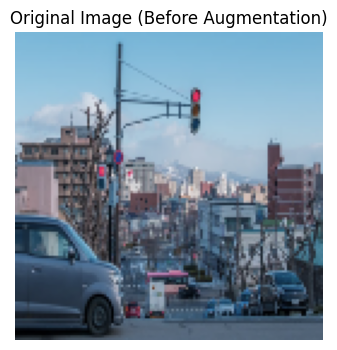

In [4]:
import matplotlib.pyplot as plt
import random

def show_random_original_image(X_balanced):
    """Displays a random image from the dataset before augmentation."""
    random_index = random.randint(0, len(X_balanced) - 1)
    sample_image = X_balanced[random_index]

    # Convert back to [0,255] for visualization
    sample_image = (sample_image * 255).astype(np.uint8)

    plt.figure(figsize=(4, 4))
    plt.imshow(sample_image)
    plt.axis("off")
    plt.title("Original Image (Before Augmentation)")
    plt.show()

show_random_original_image(X_balanced)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

# Target number of samples per image
AUGMENTATION_FACTOR = 20  # Generate 20x the original dataset

# Create empty lists for augmented data
X_augmented, y_augmented = [], []

# Loop through each image in the balanced dataset
for i in range(len(X_balanced)):
    img = X_balanced[i]
    label = y_balanced[i]  # Keep as integer

    # Expand dimensions to make it a batch of 1
    img = np.expand_dims(img, axis=0)

    # Generate multiple augmented images for each original
    aug_iter = datagen.flow(img, batch_size=1, seed=42)  # Seed for reproducibility

    for _ in range(AUGMENTATION_FACTOR):
        aug_img = next(aug_iter)[0]  # Extract the augmented image

        X_augmented.append(aug_img)
        y_augmented.append(int(label))  # ✅ Keep integer labels

# Convert lists to numpy arrays
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

print(f"Dataset size after augmentation: {X_augmented.shape[0]} samples")
print("Unique Labels After Augmentation:", np.unique(y_augmented))  # ✅ Should contain [0,1,2,3]


Dataset size after augmentation: 4880 samples
Unique Labels After Augmentation: [0 1 2 3]


In [6]:
from collections import Counter
from sklearn.utils import resample

# Convert labels back to integers for balancing
y_labels = y_augmented

# Count occurrences of each class
class_counts = Counter(y_labels)
print("Class Distribution After Undersampling and Aug:", class_counts)




Class Distribution After Undersampling and Aug: Counter({0: 1220, 2: 1220, 3: 1220, 1: 1220})


In [7]:
#show shape of X_augmented
print(X_augmented.shape)

#total amount of rows
print(len(X_augmented))

(4880, 128, 128, 3)
4880


In [8]:
#show shape of y_augmented
print(y_augmented.shape)

#total amount of rows
print(len(y_augmented))

(4880,)
4880


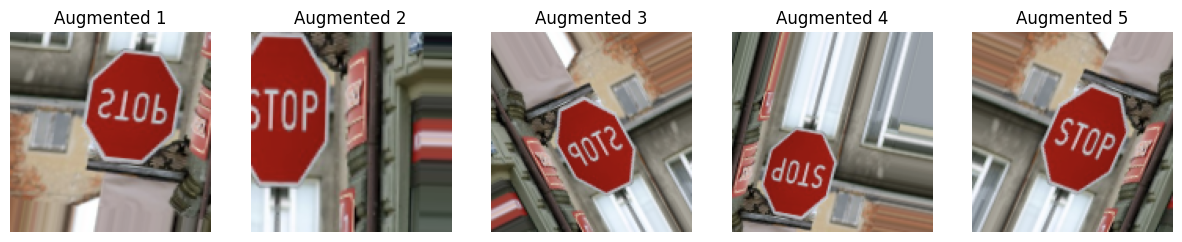

In [9]:
import matplotlib.pyplot as plt
import random

def show_augmented_images(datagen, X_balanced, num_images=5):
    """Displays randomly selected augmented images."""
    random_index = random.randint(0, len(X_balanced) - 1)
    sample_image = X_balanced[random_index]  # Select a random image

    # Expand dimensions (ImageDataGenerator expects batch input)
    sample_image = np.expand_dims(sample_image, axis=0)

    # Generate augmented images
    augmented_images = [datagen.flow(sample_image, batch_size=1)[0][0] for _ in range(num_images)]

    # Plot the images
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(augmented_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Augmented {i+1}")

    plt.show()

# Call the function to visualize
show_augmented_images(datagen, X_balanced, num_images=5)


In [10]:
from sklearn.model_selection import train_test_split
from collections import Counter

# Shuffle the dataset after augmentation
X_shuffled, y_shuffled = shuffle(X_augmented, y_augmented, random_state=42)

# Split into train (80%), validation (10%), test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_shuffled, y_shuffled, test_size=0.1, stratify=y_shuffled, random_state=42
)

# Split temp set into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.1, stratify=y_temp, random_state=42
)

# Print class distributions
print("Final Training Set Distribution:", Counter(y_train))
print("Validation Set Distribution:", Counter(y_val))
print("Test Set Distribution:", Counter(y_test))


Final Training Set Distribution: Counter({1: 1098, 3: 1098, 0: 1098, 2: 1098})
Validation Set Distribution: Counter({0: 110, 1: 110, 3: 110, 2: 109})
Test Set Distribution: Counter({2: 13, 0: 12, 1: 12, 3: 12})


In [11]:
print("Unique Labels After Augmentation:", np.unique(y_augmented))


Unique Labels After Augmentation: [0 1 2 3]


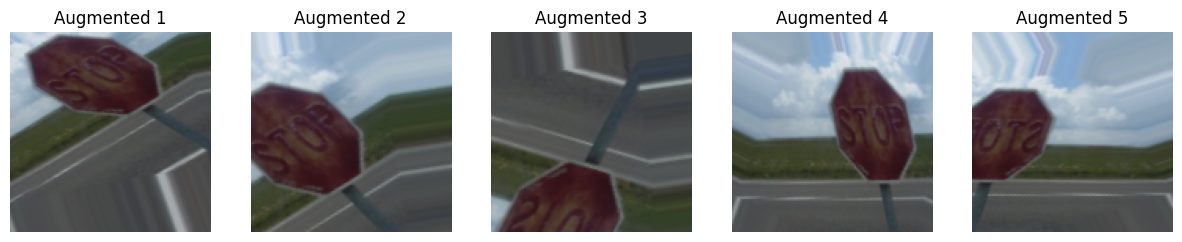

In [12]:
show_augmented_images(datagen, X_test, num_images=5)


In [13]:
from collections import Counter

train_labels = y_train
print("Train Set Class Distribution:", Counter(train_labels))


Train Set Class Distribution: Counter({1: 1098, 3: 1098, 0: 1098, 2: 1098})


In [14]:
# ✅ One-hot encode your target labels
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4) #Assuming 4 classes based on your previous code
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)  # Also encode y_test for evaluation

# Build the improved CNN model and compile it:
num_classes = 4  # Assuming 4 classes based on your previous code

In [15]:
print("Final Training Set Distribution:", Counter(np.argmax(y_train, axis=1)))
print("Validation Set Distribution:", Counter(np.argmax(y_val, axis=1)))
print("Test Set Distribution:", Counter(np.argmax(y_test, axis=1)))


Final Training Set Distribution: Counter({1: 1098, 3: 1098, 0: 1098, 2: 1098})
Validation Set Distribution: Counter({0: 110, 1: 110, 3: 110, 2: 109})
Test Set Distribution: Counter({2: 13, 0: 12, 1: 12, 3: 12})


In [16]:
assert len(X_augmented) == len(y_augmented), "Mismatch between images and labels after augmentation!"
print("Dataset size after augmentation:", len(X_augmented))
print("Label distribution after augmentation:", Counter(y_augmented))


Dataset size after augmentation: 4880
Label distribution after augmentation: Counter({0: 1220, 2: 1220, 3: 1220, 1: 1220})


In [17]:
def build_improved_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation="relu", padding="same", input_shape=X_train.shape[1:]),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        Conv2D(64, (3,3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        Conv2D(128, (3,3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        Conv2D(256, (3,3), activation="relu", padding="same"),  # Added a deeper layer
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        GlobalAveragePooling2D(),
        Dense(256, activation="relu"),  # Increased dense layer size
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_improved_cnn()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# Build model
model = build_improved_cnn ()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 457,156 (1.74 MB)

 Trainable params: 456,196 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [19]:


# Training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5012 - loss: 1.1321

138/138 ━━━━━━━━━━━━━━━━━━━━ 35s 181ms/step - accuracy: 0.5018 - loss: 1.1312 - val_accuracy: 0.2551 - val_loss: 1.6232 - learning_rate: 1.0000e-04
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.6642 - loss: 0.8270 - val_accuracy: 0.2255 - val_loss: 1.8413 - learning_rate: 1.0000e-04
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7061 - loss: 0.7261

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.7062 - loss: 0.7259 - val_accuracy: 0.4169 - val_loss: 1.3977 - learning_rate: 1.0000e-04
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7422 - loss: 0.6740

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.7423 - loss: 0.6739 - val_accuracy: 0.7198 - val_loss: 0.7033 - learning_rate: 1.0000e-04
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7659 - loss: 0.5964

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.7660 - loss: 0.5964 - val_accuracy: 0.8178 - val_loss: 0.4802 - learning_rate: 1.0000e-04
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8020 - loss: 0.5355

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8020 - loss: 0.5355 - val_accuracy: 0.8497 - val_loss: 0.4377 - learning_rate: 1.0000e-04
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8122 - loss: 0.5093

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.8122 - loss: 0.5093 - val_accuracy: 0.8656 - val_loss: 0.3773 - learning_rate: 1.0000e-04
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8216 - loss: 0.4947

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.8216 - loss: 0.4946 - val_accuracy: 0.8724 - val_loss: 0.3463 - learning_rate: 1.0000e-04
Epoch 9/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8232 - loss: 0.4762

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.8232 - loss: 0.4761 - val_accuracy: 0.8952 - val_loss: 0.3108 - learning_rate: 1.0000e-04
Epoch 10/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8442 - loss: 0.4199 - val_accuracy: 0.8815 - val_loss: 0.3135 - learning_rate: 1.0000e-04
Epoch 11/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8530 - loss: 0.4056

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8530 - loss: 0.4056 - val_accuracy: 0.8975 - val_loss: 0.2890 - learning_rate: 1.0000e-04
Epoch 12/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8543 - loss: 0.4009

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8543 - loss: 0.4009 - val_accuracy: 0.9112 - val_loss: 0.2592 - learning_rate: 1.0000e-04
Epoch 13/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8642 - loss: 0.3582 - val_accuracy: 0.8770 - val_loss: 0.3078 - learning_rate: 1.0000e-04
Epoch 14/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8690 - loss: 0.3714

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8690 - loss: 0.3715 - val_accuracy: 0.9089 - val_loss: 0.2370 - learning_rate: 1.0000e-04
Epoch 15/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8886 - loss: 0.3234

138/138 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.8886 - loss: 0.3235 - val_accuracy: 0.9339 - val_loss: 0.1921 - learning_rate: 1.0000e-04
Epoch 16/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.8769 - loss: 0.3326 - val_accuracy: 0.9362 - val_loss: 0.2098 - learning_rate: 1.0000e-04
Epoch 17/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8841 - loss: 0.3142 - val_accuracy: 0.9066 - val_loss: 0.2280 - learning_rate: 1.0000e-04
Epoch 18/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8898 - loss: 0.3021 - val_accuracy: 0.9362 - val_loss: 0.2013 - learning_rate: 1.0000e-04
Epoch 19/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9089 - loss: 0.2617

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.9089 - loss: 0.2618 - val_accuracy: 0.9544 - val_loss: 0.1734 - learning_rate: 5.0000e-05
Epoch 20/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9030 - loss: 0.2616

138/138 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.9030 - loss: 0.2616 - val_accuracy: 0.9590 - val_loss: 0.1536 - learning_rate: 5.0000e-05
Epoch 21/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9060 - loss: 0.2634

138/138 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.9060 - loss: 0.2634 - val_accuracy: 0.9567 - val_loss: 0.1280 - learning_rate: 5.0000e-05
Epoch 22/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9073 - loss: 0.2534 - val_accuracy: 0.9499 - val_loss: 0.1500 - learning_rate: 5.0000e-05
Epoch 23/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9123 - loss: 0.2401 - val_accuracy: 0.9590 - val_loss: 0.1499 - learning_rate: 5.0000e-05
Epoch 24/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9228 - loss: 0.2336

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.9227 - loss: 0.2336 - val_accuracy: 0.9658 - val_loss: 0.1091 - learning_rate: 5.0000e-05
Epoch 25/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9180 - loss: 0.2329 - val_accuracy: 0.9636 - val_loss: 0.1174 - learning_rate: 5.0000e-05
Epoch 26/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9257 - loss: 0.2219 - val_accuracy: 0.9590 - val_loss: 0.1452 - learning_rate: 5.0000e-05
Epoch 27/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9127 - loss: 0.2342 - val_accuracy: 0.9522 - val_loss: 0.1131 - learning_rate: 5.0000e-05
Epoch 28/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9269 - loss: 0.2130

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.9269 - loss: 0.2130 - val_accuracy: 0.9749 - val_loss: 0.0931 - learning_rate: 2.5000e-05
Epoch 29/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9374 - loss: 0.1890 - val_accuracy: 0.9727 - val_loss: 0.0968 - learning_rate: 2.5000e-05
Epoch 30/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9352 - loss: 0.1957

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.9352 - loss: 0.1957 - val_accuracy: 0.9749 - val_loss: 0.0876 - learning_rate: 2.5000e-05
Epoch 31/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9344 - loss: 0.1971 - val_accuracy: 0.9613 - val_loss: 0.1074 - learning_rate: 2.5000e-05
Epoch 32/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9360 - loss: 0.1889 - val_accuracy: 0.9681 - val_loss: 0.0935 - learning_rate: 2.5000e-05
Epoch 33/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9378 - loss: 0.1840 - val_accuracy: 0.9613 - val_loss: 0.1176 - learning_rate: 2.5000e-05
Epoch 34/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9360 - loss: 0.1770

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9360 - loss: 0.1770 - val_accuracy: 0.9704 - val_loss: 0.0812 - learning_rate: 1.2500e-05
Epoch 35/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9488 - loss: 0.1659

138/138 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.9488 - loss: 0.1660 - val_accuracy: 0.9772 - val_loss: 0.0804 - learning_rate: 1.2500e-05
Epoch 36/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9318 - loss: 0.1871 - val_accuracy: 0.9749 - val_loss: 0.0830 - learning_rate: 1.2500e-05
Epoch 37/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9404 - loss: 0.1698 - val_accuracy: 0.9658 - val_loss: 0.0870 - learning_rate: 1.2500e-05
Epoch 38/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9364 - loss: 0.1745 - val_accuracy: 0.9749 - val_loss: 0.0815 - learning_rate: 1.2500e-05
Epoch 39/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9427 - loss: 0.1620

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.9427 - loss: 0.1621 - val_accuracy: 0.9727 - val_loss: 0.0788 - learning_rate: 6.2500e-06
Epoch 40/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9416 - loss: 0.1728

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.9416 - loss: 0.1728 - val_accuracy: 0.9704 - val_loss: 0.0765 - learning_rate: 6.2500e-06
Epoch 41/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9467 - loss: 0.1570 - val_accuracy: 0.9704 - val_loss: 0.0842 - learning_rate: 6.2500e-06
Epoch 42/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9400 - loss: 0.1781 - val_accuracy: 0.9795 - val_loss: 0.0806 - learning_rate: 6.2500e-06
Epoch 43/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9379 - loss: 0.1722 - val_accuracy: 0.9772 - val_loss: 0.0838 - learning_rate: 6.2500e-06
Epoch 44/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9403 - loss: 0.1619 - val_accuracy: 0.9772 - val_loss: 0.0794 - learning_rate: 3.1250e-06
Epoch 45/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9393 - loss: 0.1665 - val_accuracy: 0.9704 - val_loss: 0.0794 - learning_rate: 3.1250e-06
Epoch 46/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/st

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.9407 - loss: 0.1717 - val_accuracy: 0.9749 - val_loss: 0.0762 - learning_rate: 3.1250e-06
Epoch 47/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9436 - loss: 0.1691

138/138 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.9436 - loss: 0.1690 - val_accuracy: 0.9727 - val_loss: 0.0756 - learning_rate: 3.1250e-06
Epoch 48/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9416 - loss: 0.1696

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.9416 - loss: 0.1696 - val_accuracy: 0.9704 - val_loss: 0.0742 - learning_rate: 3.1250e-06
Epoch 49/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9347 - loss: 0.1853

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.9348 - loss: 0.1852 - val_accuracy: 0.9749 - val_loss: 0.0740 - learning_rate: 3.1250e-06
Epoch 50/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9470 - loss: 0.1586

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9470 - loss: 0.1586 - val_accuracy: 0.9727 - val_loss: 0.0732 - learning_rate: 3.1250e-06


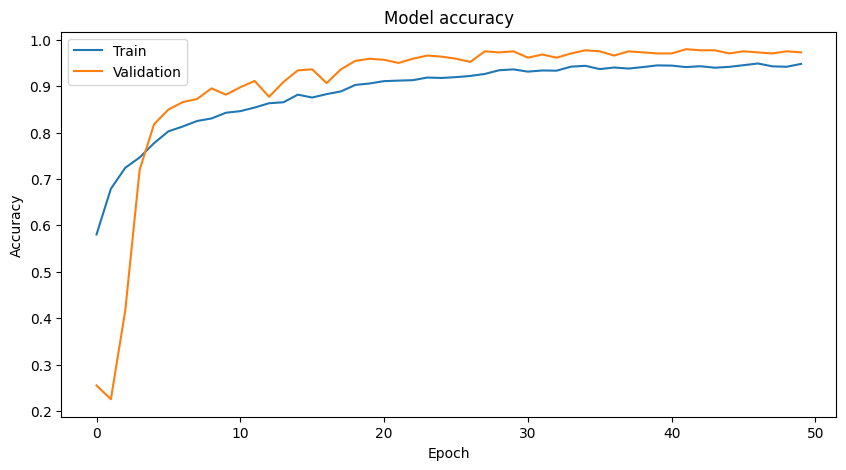

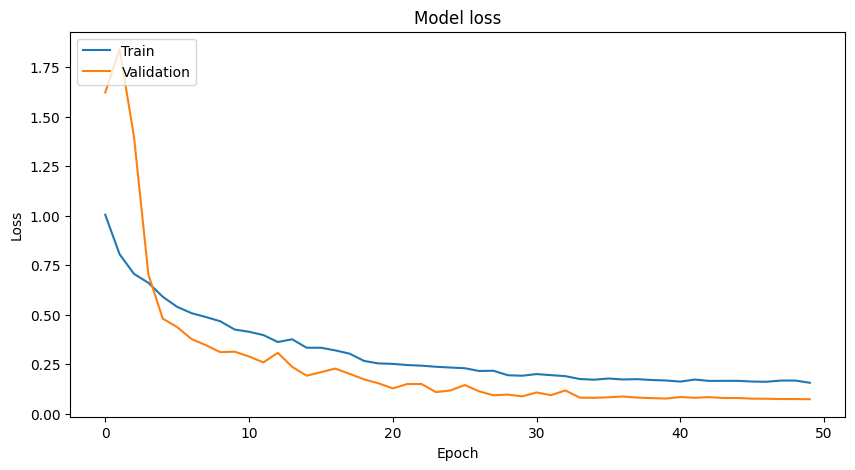

In [22]:
# prompt: create a line graph of the acc and loss of the train and the validation sets

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9384 - loss: 0.1562
Balanced Test Accuracy: 0.94
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


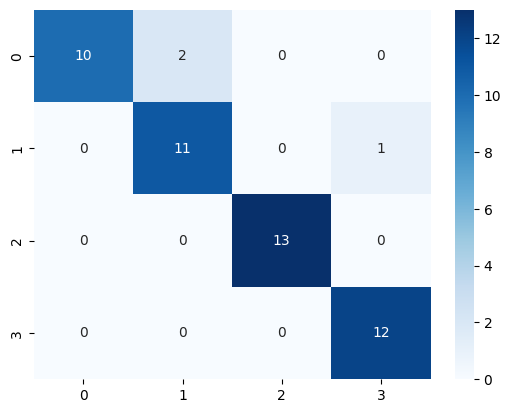

              precision    recall  f1-score   support

   crosswalk       1.00      0.83      0.91        12
  speedlimit       0.85      0.92      0.88        12
        stop       1.00      1.00      1.00        13
trafficlight       0.92      1.00      0.96        12

    accuracy                           0.94        49
   macro avg       0.94      0.94      0.94        49
weighted avg       0.94      0.94      0.94        49



In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Balanced Test Accuracy: {test_acc:.2f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))


In [25]:
import pickle
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming `y` is your original label array from training
y = np.array(["crosswalk", "speedlimit", "stop", "trafficlight"])  # Example classes

# Fit the label encoder
label_encoder = LabelEncoder()
label_encoder.fit(y)

# Save label encoder to a file
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("Label encoder saved successfully!")


Label encoder saved successfully!


In [24]:
pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [26]:
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2
import pickle

# Load trained model
model = tf.keras.models.load_model("best_model.h5")

# Load label encoder
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Define image processing function
TARGET_SIZE = (128, 128)

def predict(image):
    """Preprocess image, classify, and return label."""

    # Resize and normalize image
    image = cv2.resize(image, TARGET_SIZE)
    image = np.array(image).astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction, axis=1)[0]  # Get class index

    # Convert class index to label
    predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]

    return f"Predicted Class: {predicted_label}"

# Create Gradio Interface
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Textbox(),
    title="Traffic Sign Classifier",
    description="Upload an image and get a classification!"
)

# Launch Gradio app
iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://56e908515360d821be.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
